In [ ]:
# !pip install --upgrade yfinance

In [ ]:
# !pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import logging
import multiprocessing
from datetime import datetime, timedelta

from src import modules as f
%load_ext autoreload
%autoreload 2

2025-08-10 23:08:33.195968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754892513.240179    9244 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754892513.255849    9244 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Download, load, extract, model...
interval = '1mo'
stock_set = f.download_interval_process(interval, 1)
print(f'Stock set: \n{stock_set}\n')

In [ ]:
f.make_table_features_process(stock_set, interval, 7)

In [ ]:
f.make_master_table(stock_set, interval)

In [ ]:
f.xg_boost_model(interval, grid_search_on=True)

In [8]:
symbol = 'mstr'.upper()
interval = '1d'
f.model_prospect(symbol, interval, build=False)
df_val = f.model_validation(symbol, interval)
correctly_predicted = df_val.dir_pred_match.sum()
print(f'\nCorrectly Predicted: {correctly_predicted}')
entries_predicted = df_val.shape[0]
print(f'Entries Predicted: {entries_predicted}')
p = correctly_predicted / entries_predicted # percent correct
print(f'Percent Correct: {p}')
print(f'Kelly Criterion: {f.kelly_c(p=[p], l=1, g=2)[0]:.2%}')


Model Prediction 1d MSTR:
MSTR last price: 394.39
Predicted Next 1d Movement: UP

Model Prediction Probabilities:
no_change (0): 0.3330
up (1): 0.3338
down (2): 0.3332

Last Entry 1d MSTR Datetime Used for Prediction:
NOTE: It's in or contains the full 1d time interval.
EST: 2025-08-12 12:00:00 AM EDT-0400
PDT: 2025-08-11 09:00:00 PM PDT-0700

Correctly Predicted: 39
Entries Predicted: 100
Percent Correct: 0.39
Kelly Criterion: 8.50%


In [ ]:
# regressor model 
# Train the 15-step-ahead model on your aggregated data:
f.xg_boost_reg_model(interval="1mo", grid_search_on=True)

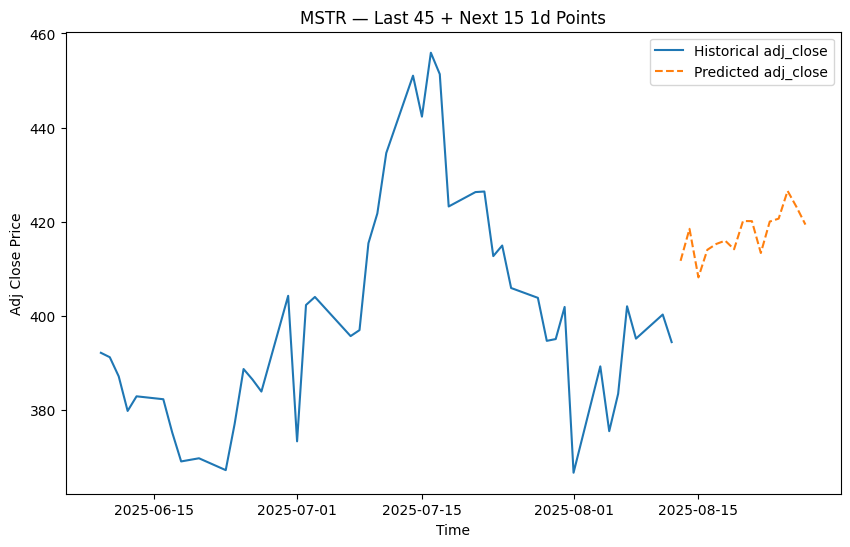

In [9]:
# Then for any symbol, plot the last 45 days plus the next 15-day forecast:
f.plot_adj_close("mstr", interval="1d")

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

stock_symbol = 'NVDA'.upper()
interval = '1d'
f.download(stock_symbol, interval)
stock_data = f.load_raw(stock_symbol, interval)
stock_data

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['close'])
plt.title(f'{stock_symbol} closing price')
plt.show()

In [ ]:
#Distribution of the dataset
df_close = stock_data['close']
df_close.plot(kind='kde')

In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

In [ ]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
# Ensure training data is tz-naive and has BusinessDay frequency
train_data = train_data.copy()
train_data.index = train_data.index.tz_localize(None)
train_data = train_data.asfreq('B')

# If your data are in log scale and you wish to forecast on that scale, use trend='t' (drift)
model = ARIMA(train_data, order=(1,1,2), trend='t')
fitted = model.fit()
print(fitted.summary())

In [ ]:
# Set this flag: True if your model and data are in log scale; False if in level scale.
log_data = True

# ----- Prepare Training Data -----
train_data = train_data.copy()
train_data.index = train_data.index.tz_localize(None)
# Force training data to have BusinessDay frequency.
train_data = train_data.asfreq('B')  # Now train_data.index has frequency, e.g. "<BusinessDay>"

# ----- Prepare Test Data -----
freq = train_data.index.freq  # should be <BusinessDay>
test_index = pd.date_range(
    start=train_data.index[-1] + pd.Timedelta(days=1),
    periods=len(test_data),
    freq=freq
)
test_data = test_data.copy()
test_data.index = test_index

print("Training data last date:", train_data.index[-1])
print("Test data first date:", test_data.index[0])
assert test_data.index[0] > train_data.index[-1], "Test data index does not extend training data!"

# ----- Update Model State -----
fitted.model.data.orig_endog.index = train_data.index
fitted.model.data.dates = train_data.index

fitted_updated = fitted.append(test_data, refit=False)

# ----- Forecast Simulation Using get_forecast -----
forecast_steps = 321
forecast_object = fitted_updated.get_forecast(steps=forecast_steps)
fc_series = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05)

# Rename the CI columns (if necessary)
conf_int.columns = ['lower', 'upper']

# For debugging, print a summary of the CI values.
print("CI summary:\n", conf_int.describe())

# If the model is built on log-scale data, convert forecasts and intervals back to price levels.
if log_data:
    fc_series = np.exp(fc_series)
    conf_int = np.exp(conf_int)
    last_actual_value = np.exp(test_data.iloc[-1])
else:
    last_actual_value = test_data.iloc[-1]

# Prepend the last observed test value so the forecast connects.
fc_series_full = pd.concat([pd.Series([last_actual_value], index=[test_data.index[-1]]), fc_series])
conf_int_full = pd.concat([
    pd.DataFrame({"lower": [last_actual_value], "upper": [last_actual_value]}, index=[test_data.index[-1]]),
    conf_int
])

# (Optional for debugging) – You could widen the CI band temporarily for visibility.
# For example, multiply the difference by 3:
# conf_int_full["upper"] = fc_series_full + 3*(conf_int_full["upper"] - fc_series_full)
# conf_int_full["lower"] = fc_series_full - 3*(fc_series_full - conf_int_full["lower"])

# ----- Plotting -----
plt.figure(figsize=(10, 5), dpi=100)
if log_data:
    plt.plot(np.exp(train_data), label='Training Data', zorder=1)
    plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price', zorder=2)
else:
    plt.plot(train_data, label='Training Data', zorder=1)
    plt.plot(test_data, color='blue', label='Actual Stock Price', zorder=2)

# Fill the CI band.
plt.fill_between(conf_int_full.index,
                 conf_int_full["lower"],
                 conf_int_full["upper"],
                 color='lightgrey', alpha=0.5, label='95% CI', zorder=3)

# Plot the forecast as a bold orange line.
plt.plot(fc_series_full.index, fc_series_full,
         color='orange', linewidth=3, label='Forecast', zorder=4)

plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{stock_symbol} Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
